In [1]:
# Load the data
# Explore the data format
# Create a vocabulary

In [2]:
import pickle
import numpy as np

In [3]:
with open('train_qa.txt', 'rb') as f:
  train_data = pickle.load(f)

In [4]:
with open('test_qa.txt', 'rb') as f:
  test_data = pickle.load(f)

In [5]:
type(train_data)

list

In [6]:
type(test_data)

list

In [7]:
len(train_data)

10000

In [8]:
len(test_data)

1000

In [9]:
# The train data is a list of tuples of the story, question, answer
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [10]:
' '.join(train_data[0][0])

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [11]:
' '.join(train_data[0][1])

'Is Sandra in the hallway ?'

In [12]:
train_data[0][2]

'no'

In [13]:
# Now, a vocabulary of the dataset is built [Both train and test data must be taken into account]

all_data = test_data + train_data
len(all_data)

11000

Creating a vocabulary of all words in our dataset.

In [14]:
set(train_data[0][0])

{'.',
 'Mary',
 'Sandra',
 'bathroom',
 'bedroom',
 'journeyed',
 'moved',
 'the',
 'to'}

In [15]:
vocab = set()

for story, question, answer in all_data:
  # Set of words in stories in all_data
  vocab = vocab.union(set(story))
  # Set of words in questions in all_data
  vocab = vocab.union(set(question))

# Set of words in answers in all_data
vocab.add('no')
vocab.add('yes')

In [16]:
print(vocab, end = ' ')

{'bedroom', 'bathroom', 'Is', 'up', 'got', '?', 'hallway', 'discarded', 'in', 'picked', 'travelled', 'to', 'down', 'took', 'dropped', 'there', 'left', 'went', 'the', 'John', 'grabbed', 'put', 'Mary', 'yes', 'office', 'no', 'milk', 'back', 'apple', 'moved', 'Daniel', 'garden', 'football', '.', 'journeyed', 'kitchen', 'Sandra'} 

In [17]:
# Increasing vocabulary length by 1, as keras padding sequences uses 0 as a placeholder
vocab_length = len(vocab) + 1
vocab_length

38

In [18]:
# Longest story length (needed for keras padding sequences)
all_story_lengths = [len(data[0]) for data in all_data]
max_story_len = max(all_story_lengths)
max_story_len

156

In [19]:
# Longest question length (needed for keras padding sequences)
all_question_lengths = [len(data[1]) for data in all_data]
max_question_len = max(all_question_lengths)
max_question_len

6

Vectorizing the data.

In [20]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

# Creating an integer encoding for the sequences of words
tokenizer = Tokenizer(filters = [])
tokenizer.fit_on_texts(vocab)

# Words get lowercased automatically in this manner too
tokenizer.word_index 

{'.': 34,
 '?': 6,
 'apple': 29,
 'back': 28,
 'bathroom': 2,
 'bedroom': 1,
 'daniel': 31,
 'discarded': 8,
 'down': 13,
 'dropped': 15,
 'football': 33,
 'garden': 32,
 'got': 5,
 'grabbed': 21,
 'hallway': 7,
 'in': 9,
 'is': 3,
 'john': 20,
 'journeyed': 35,
 'kitchen': 36,
 'left': 17,
 'mary': 23,
 'milk': 27,
 'moved': 30,
 'no': 26,
 'office': 25,
 'picked': 10,
 'put': 22,
 'sandra': 37,
 'the': 19,
 'there': 16,
 'to': 12,
 'took': 14,
 'travelled': 11,
 'up': 4,
 'went': 18,
 'yes': 24}

In [21]:
# Separating the stories, questions and answers from each other and storing them into lists
train_story_text = []
train_question_text = []
train_answers = []

for story, question, answer in train_data:
  train_story_text.append(story)
  train_question_text.append(question)
  train_answers.append(answer)


In [22]:
train_story_text[0:2]

[['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.',
  'Mary',
  'went',
  'back',
  'to',
  'the',
  'bedroom',
  '.',
  'Daniel',
  'went',
  'back',
  'to',
  'the',
  'hallway',
  '.']]

In [23]:
# Creating the sequences from the story texts using the tokenizer
train_story_seq = tokenizer.texts_to_sequences(train_story_text)
len(train_story_seq)

10000

In [24]:
train_story_seq[0]

[23, 30, 12, 19, 2, 34, 37, 35, 12, 19, 1, 34]

In [25]:
# Function to vectorize the stories, questions and answers into padded sequences

def vectorize_stories(data, word_index = tokenizer.word_index, max_story_len = max_story_len,
                      max_question_len = max_question_len):
  
# max_story_len takes care of inputting constant length to the RNN by either cutting short the 
# sentence if it is too long, or adding zeroes if it is too short
# Similarly for the question lengths

  X = [] # List for storing sequence lists of each story
  Xq = [] # List for storing sequence lists of each question
  Y = [] # List for storing sequences lists of each answer

  for story, question, answer in data:
    x = [word_index[word.lower()] for word in story] # For each word in the current story
    xq = [word_index[word.lower()] for word in question] # For each word in the current question
    
    # Since our answers are confined to 'Yes' or 'No', we can manually do the word index process for it
    # We add 1 for the keras padding sequence
    y = np.zeros(len(word_index)+1)
    y[word_index[answer]] = 1

    X.append(x)
    Xq.append(xq)
    Y.append(y)

  # Pad the sequences obtained from the for loop
  return (pad_sequences(X, maxlen = max_story_len), pad_sequences(Xq, maxlen = max_question_len), np.array(Y))

In [26]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

In [27]:
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [28]:
inputs_test[:2]

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        23,  5, 19, 27, 16, 34, 20, 30, 12, 19,  1, 34],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
       

In [29]:
answers_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [30]:
tokenizer.word_index['yes']

24

In [31]:
tokenizer.word_index['no']

26

In [32]:
sum(answers_test)

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0., 497.,   0., 503.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.])

Building the Neural Network.

In [33]:
# Network uses
# Input Encoder M
# Input Encoder C
# Question Encoder

from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate, LSTM

# Placeholder for our story. shape = (max_story_len, batch_size)
# Similarly for our questions
input_sequence = Input((max_story_len,))
question = Input((max_question_len,))

In [34]:
# Previously declared as vocab_len
vocab_size = len(vocab) + 1

In [35]:
# Input encoder M
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim = vocab_size, output_dim= 64))
input_encoder_m.add(Dropout(0.3))

# This will give us (samples, story_maxLen, embedding_dim)

In [36]:
# Input encoder C
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim = vocab_size, output_dim= max_question_len))
input_encoder_c.add(Dropout(0.3))

# This will give us (samples, story_maxLen, max_question_len)

In [37]:
# Question encoder
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim = vocab_size, output_dim = 64, input_length = max_question_len))
question_encoder.add(Dropout(0.3))

# This will give us (samples, query_maxLen, embedding_dim)

In [38]:
# Now the inputs are passed to all 3 encoders which were defined in the placeholder
# Encoded = Encoder(Input)
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [39]:
# Use of dot product to compute the match between the input vector sequence and the query
match = dot([input_encoded_m, question_encoded], axes = (2,2))
match = Activation('softmax')(match)

In [40]:
# Adding the matrix with the second input vector sequence
response = add([match, input_encoded_c]) # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)

In [41]:
# Concatenating the match matrix with the question vector sequence
answer = concatenate([response, question_encoded])
answer

<KerasTensor: shape=(None, 6, 220) dtype=float32 (created by layer 'concatenate')>

In [42]:
# Reducing our answer tensor with an RNN
answer = LSTM(32)(answer)

In [43]:
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer) # (samples, vocab_size)
# This will give us an answer of size vocab_size with the only possibilities being 'yes' or 'no' as answers

In [44]:
# Turning the probabilities we get for yes/no as 0/1
answer = Activation('softmax')(answer)

In [45]:
model = Model([input_sequence, question], answer)

In [46]:
# Compiling the model. We use categorical cross entropy even though we are looking only for yes/no answers as the output will involve the full vocabulary, and
# so binary cross entropy is not used
model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [47]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 156)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 sequential (Sequential)        (None, None, 64)     2432        ['input_1[0][0]']                
                                                                                                  
 sequential_2 (Sequential)      (None, 6, 64)        2432        ['input_2[0][0]']                
                                                                                              

In [48]:
# 40 epochs seem optimal when tuning the parameters
history = model.fit([inputs_train, queries_train], answers_train,batch_size=32,epochs=40,validation_data=([inputs_test, queries_test], answers_test))

Epoch 1/40
313/313 [==============================] - 8s 8ms/step - loss: 0.9065 - accuracy: 0.4911 - val_loss: 0.6981 - val_accuracy: 0.5030
Epoch 2/40
313/313 [==============================] - 2s 7ms/step - loss: 0.7047 - accuracy: 0.4969 - val_loss: 0.6955 - val_accuracy: 0.5030
Epoch 3/40
313/313 [==============================] - 2s 7ms/step - loss: 0.6968 - accuracy: 0.4914 - val_loss: 0.6934 - val_accuracy: 0.5030
Epoch 4/40
313/313 [==============================] - 2s 7ms/step - loss: 0.6947 - accuracy: 0.4985 - val_loss: 0.6932 - val_accuracy: 0.5030
Epoch 5/40
313/313 [==============================] - 2s 7ms/step - loss: 0.6947 - accuracy: 0.5018 - val_loss: 0.6931 - val_accuracy: 0.5030
Epoch 6/40
313/313 [==============================] - 2s 7ms/step - loss: 0.6949 - accuracy: 0.4958 - val_loss: 0.6931 - val_accuracy: 0.5030
Epoch 7/40
313/313 [==============================] - 2s 7ms/step - loss: 0.6945 - accuracy: 0.4972 - val_loss: 0.6933 - val_accuracy: 0.4970
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


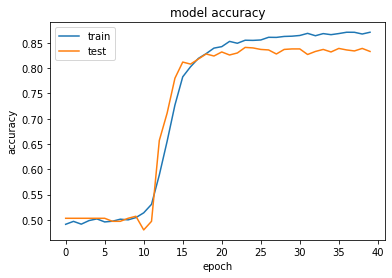

In [49]:
# Evaluating the model
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [50]:
# Saving the model
filename = 'chatbot_40_epochs.h5'
model.save(filename)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [51]:
# Predicting on the inputs_test and queries_test
pred_results = model.predict(([inputs_test, queries_test]))

In [52]:
test_data[0][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

In [53]:
test_data[0][1]

['Is', 'John', 'in', 'the', 'kitchen', '?']

In [54]:
test_data[0][2]

'no'

In [55]:
pred_results

array([[1.5815885e-12, 1.2487648e-12, 1.4278217e-12, ..., 1.2726904e-12,
        1.1052688e-12, 1.6184833e-12],
       [2.3497350e-13, 1.8198050e-13, 2.2243831e-13, ..., 1.9122422e-13,
        1.7847532e-13, 2.2426420e-13],
       [2.4967008e-09, 2.2003155e-09, 2.1986415e-09, ..., 2.2867970e-09,
        2.9137048e-09, 1.6879416e-09],
       ...,
       [1.7111230e-13, 1.2838766e-13, 1.4626185e-13, ..., 1.2744757e-13,
        1.2841753e-13, 1.6575726e-13],
       [2.4579205e-11, 2.0227212e-11, 2.2653665e-11, ..., 2.3121977e-11,
        3.2162422e-11, 1.5442800e-11],
       [4.1467604e-11, 3.6039362e-11, 4.1447835e-11, ..., 4.0461454e-11,
        4.4473484e-11, 3.3991858e-11]], dtype=float32)

In [56]:
# pred_results contains 1000 stories, their questions and their answers with a vocab size of 37 plus one for padding
pred_results.shape

(1000, 38)

In [57]:
# It returns the probabilities of each words as the answer for a given question. It would be liked that yes/no will have
# higher in these cases
pred_results[0]

array([1.5815885e-12, 1.2487648e-12, 1.4278217e-12, 1.3074769e-12,
       1.4604276e-12, 1.3426197e-12, 1.4300785e-12, 1.4748212e-12,
       1.5945526e-12, 1.4111009e-12, 1.2794029e-12, 1.3653506e-12,
       1.0307150e-12, 1.0233068e-12, 1.5810033e-12, 1.3425993e-12,
       1.3057175e-12, 1.1073577e-12, 1.5770881e-12, 1.2650909e-12,
       1.2973663e-12, 1.3541157e-12, 1.3847688e-12, 1.1678462e-12,
       7.1233872e-04, 1.1145920e-12, 9.9928766e-01, 1.3976916e-12,
       1.3769046e-12, 1.1455771e-12, 1.3119084e-12, 1.5816970e-12,
       1.0918295e-12, 1.1341889e-12, 1.2137705e-12, 1.2726904e-12,
       1.1052688e-12, 1.6184833e-12], dtype=float32)

In [58]:
# Obtaining the highest probabilities
val_max = np.argmax(pred_results[0])
val_max

26

In [59]:
# Looking up the word from the tokenizer using the highest probability as the value
for key, val in tokenizer.word_index.items():
  if val == val_max:
    k = key
print(k)

no


In [60]:
# Checking how sure the model is about its answer
pred_results[0][val_max]

0.99928766

In [61]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [62]:
# Testing with custom output using vocabulary the model is trained on
my_story = "Daniel left the office . Sandra dropped milk in the garden ."
# Formatting the story into the form the train and test datasets had the stories in
my_story.split()

['Daniel',
 'left',
 'the',
 'office',
 '.',
 'Sandra',
 'dropped',
 'milk',
 'in',
 'the',
 'garden',
 '.']

In [63]:
my_question = "Is the milk in the garden ?"
# Formatting into the same form as the train and test datasets
my_question.split()

['Is', 'the', 'milk', 'in', 'the', 'garden', '?']

In [64]:
my_test_data = [(my_story.split(), my_question.split(), 'yes')]
my_test_data

[(['Daniel',
   'left',
   'the',
   'office',
   '.',
   'Sandra',
   'dropped',
   'milk',
   'in',
   'the',
   'garden',
   '.'],
  ['Is', 'the', 'milk', 'in', 'the', 'garden', '?'],
  'yes')]

In [65]:
my_story, my_ques, my_ans = vectorize_stories(my_test_data)

In [66]:
my_story

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        31, 17, 19, 25, 34, 37, 15, 27,  9, 19, 32, 34]], dtype=int32)

In [67]:
my_ques

array([[19, 27,  9, 19, 32,  6]], dtype=int32)

In [68]:
my_ans

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]])

In [69]:
# Calling the model with the custom test story and question
pred_results = model.predict(([my_story, my_ques]))

In [70]:
pred_results

array([[2.3378391e-10, 2.2713201e-10, 2.0835014e-10, 2.0238099e-10,
        1.9226726e-10, 1.8298880e-10, 2.2297010e-10, 2.0942666e-10,
        2.2737733e-10, 2.7674021e-10, 1.8559201e-10, 1.9137672e-10,
        2.0506756e-10, 2.1743395e-10, 1.8936371e-10, 1.6859776e-10,
        2.2981551e-10, 2.0361535e-10, 2.2533952e-10, 2.3223817e-10,
        2.2356800e-10, 1.8155645e-10, 2.7324604e-10, 1.8886952e-10,
        8.7569976e-01, 2.4738134e-10, 1.2430023e-01, 1.9920612e-10,
        1.8042211e-10, 2.2257327e-10, 2.2466060e-10, 1.9773809e-10,
        2.2290292e-10, 1.4515475e-10, 1.5840532e-10, 2.1256324e-10,
        2.5147839e-10, 1.7681974e-10]], dtype=float32)

In [71]:
# Obtaining the highest probabilities
val_max = np.argmax(pred_results[0])
val_max

24

In [72]:
# Looking up the word from the tokenizer using the highest probability as the value
for key, val in tokenizer.word_index.items():
  if val == val_max:
    k = key
print(k)

yes


In [73]:
# Checking how sure the model is about its answer
pred_results[0][val_max]

0.87569976